In [249]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBClassifier

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


In [250]:
#importing datasets
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Null Values

In [251]:
#dealing with null values in the train dataset
null = train.isna().sum().sort_values(ascending = False)
null_2 = test.isna().sum().sort_values(ascending = False)
null_values = pd.concat([null, null_2], keys = ['train null', 'test null'], axis = 1)
null_values.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


,train null,test null
Age,177,86.0
Cabin,687,327.0
Embarked,2,0.0
Fare,0,1.0
Name,0,0.0


In [252]:
#replace all missing values in the age column w/the mean.
x = train.iloc[:, -7].values
x = x.reshape(-1,1)
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(x)
x = imputer.transform(x)
train.iloc[:, -7] = x
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [253]:
#replace all missing values in the age column w/the mean.(test)
x = test.iloc[:, -7].values
x = x.reshape(-1,1)
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(x)
x = imputer.transform(x)
test.iloc[:, -7] = x
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [254]:
#replace all missing values in the Embarked column w/the value with highest frequency.
y = train.iloc[:, -1].values
y = y.reshape(-1,1)
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer = imputer.fit(y)
y = imputer.transform(y)
train.iloc[:, -1] = y
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

In [255]:
#dealing with the null fare value (test)
#Check the row with null Fare Value
test[test["Fare"].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [256]:
#check for Fare prices for passengers in 3rd class who embarked from Southampton.
for a,b,c in zip(test["Fare"], test["Pclass"], test["Embarked"]):
    if b == 3 and c == "S":
        fare = a

#find the average fare for these passengers
class_3_list = [fare]
from statistics import mean
m = mean(class_3_list)

#replace the nan with this average
test["Fare"].fillna(m, inplace = True) 
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64

In [257]:
#dealing w/missing cabin data in both datasets
import re
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [train, test]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)
    

## dropping less significant columns

In [258]:
#drop the cabin variable
train = train.drop(['Cabin'], axis=1)
test = test.drop(['Cabin'], axis=1)
train = train.drop(['PassengerId'], axis=1)
train = train.drop(['Ticket'], axis=1)
test = test.drop(['Ticket'], axis=1)

## Remapping categorical data to int type.

In [259]:
#remapping female/male to 0/1 in sex column 
#remapping Embarked( C, Q S) to 0/1/2 in sex column
dataset = [train, test]
for data in dataset:
    data.Sex[data.Sex == 'female'] = 0
    data.Sex[data.Sex == 'male'] = 1
    data.Embarked[data.Embarked == 'C'] = 0
    data.Embarked[data.Embarked == 'Q'] = 1
    data.Embarked[data.Embarked == 'S'] = 2

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value

## Exploring variables relation to survival

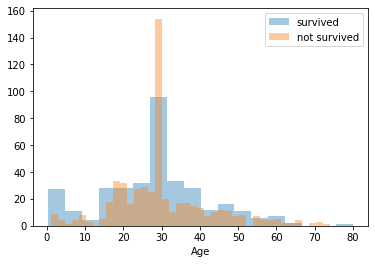

In [260]:
#age
survived = 'survived'
not_survived = 'not survived'
ax = sns.distplot(train[train['Survived']==1].Age.dropna(), bins=18, label = survived,kde =False)
ax = sns.distplot(train[train['Survived']==0].Age.dropna(), bins=40, label = not_survived,kde =False)
ax.legend()

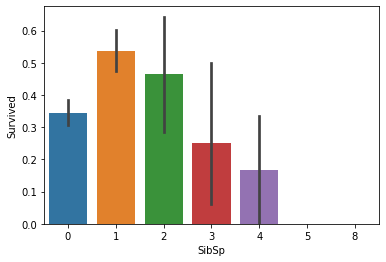

In [261]:
#sibsp
sns.barplot(x='SibSp', y='Survived', data=train)

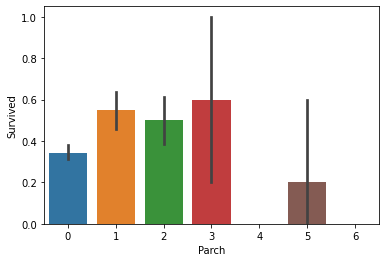

In [262]:
#parch
sns.barplot(x='Parch', y='Survived', data=train)

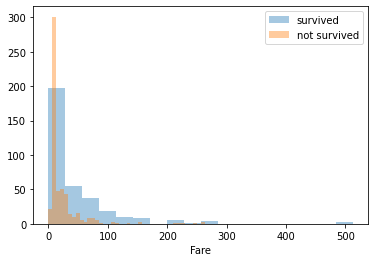

In [263]:
#fare
survived = 'survived'
not_survived = 'not survived'
ax = sns.distplot(train[train['Survived']==1].Fare.dropna(), bins=18, label = survived,kde =False)
ax = sns.distplot(train[train['Survived']==0].Fare.dropna(), bins=40, label = not_survived,kde =False)
ax.legend()

## creating categories

In [264]:
#creating categories
#age
data = [train, test]
for dataset in data:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 6

#sibsp
data = [train, test]
for dataset in data:
    dataset.loc[ dataset['SibSp'] == 0, 'SibSp'] = 0
    dataset.loc[(dataset['SibSp'] > 0) & (dataset['SibSp'] <= 2), 'SibSp'] = 1
    dataset.loc[(dataset['SibSp'] > 2) & (dataset['SibSp'] <= 4), 'SibSp']   = 2
    dataset.loc[ dataset['SibSp'] > 4, 'SibSp'] = 3
    dataset['SibSp'] = dataset['SibSp'].astype(int)
    
#parch
data = [train, test]
for dataset in data:
    dataset.loc[ dataset['Parch'] <= 3, 'Parch'] = 0
    dataset.loc[(dataset['Parch'] > 3) & (dataset['Parch'] <= 4), 'Parch'] = 1
    dataset.loc[(dataset['Parch'] > 4) & (dataset['Parch'] <= 5), 'Parch']   = 2
    dataset.loc[(dataset['Parch'] > 5) & (dataset['Parch'] <= 6), 'Parch']   = 3
    dataset['Parch'] = dataset['Parch'].astype(int)
    
#fare
data = [train, test]
for dataset in data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 200), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 200, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)

In [265]:
#handling the name column
data = [train, test]
titles = {"Mr": 0, "Mrs": 1, "Miss": 2, "Master": 3, "Rare": 4}

for dataset in data:
    # extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # convert titles into numbers
    dataset['Title'] = dataset['Title'].map(titles)
    # filling NaN with 0, to get safe
    dataset['Title'] = dataset['Title'].fillna(0)
train = train.drop(['Name'], axis=1)
test = test.drop(['Name'], axis=1)

In [266]:
data = [train, test]
for dataset in data:
    dataset['Age_Class']= dataset['Age']* dataset['Pclass']

## Fitting RandomForest Classifier

In [269]:
X_train.dtypes

Pclass        int64
Sex          object
Age           int64
SibSp         int64
Parch         int64
Fare          int64
Embarked     object
Deck          int64
Title         int64
Age_Class     int64
dtype: object

In [270]:
X_test.dtypes

Pclass        int64
Sex          object
Age           int64
SibSp         int64
Parch         int64
Fare          int64
Embarked     object
Deck          int64
Title         int64
Age_Class     int64
dtype: object

In [271]:
test['Embarked'] = test['Embarked'].astype(int)
test['Sex'] = test['Sex'].astype(int)
train['Embarked'] = train['Embarked'].astype(int)
train['Sex'] = train['Sex'].astype(int)

In [272]:
alg = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
                    min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                    objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)


#gradboostclassifier
X_train = train.drop("Survived", axis=1)
Y_train = train["Survived"]
X_test  = test.drop("PassengerId", axis=1).copy()


alg = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
                    min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                    objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
alg.fit(X_train, Y_train, eval_metric='auc')

Y_prediction = alg.predict(X_test)

## Submission File

In [273]:
predicted_survived = list(Y_prediction)

new_id = test.iloc[:, 0]
file = pd.DataFrame({'PassengerId':new_id, 'Survived': predicted_survived})
submission = file.set_index('PassengerId')
submission.to_csv('submission_3.csv')
